groups                                                                                            cyclic_encoding_month+month_start_end
features                                                                           [is_month_start, is_month_end, month_sin, month_cos]
params      {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}
mae                                                                                                                          821.222581
rmse                                                                                                                          968.01659
under                                                                                                                          0.530952
over                                                                                                                           0.469048
score                                           

17:49:41 - cmdstanpy - INFO - Chain [1] start processing
17:49:41 - cmdstanpy - INFO - Chain [1] done processing
17:49:41 - cmdstanpy - INFO - Chain [1] start processing
17:49:41 - cmdstanpy - INFO - Chain [1] done processing
17:49:41 - cmdstanpy - INFO - Chain [1] start processing
17:49:41 - cmdstanpy - INFO - Chain [1] done processing



📋 Metriken Prophet (Notrufe):
          Monat  MAE_Prophet  RMSE_Prophet  Under_Prophet  Over_Prophet
0      February      1032.51       1197.25           0.54          0.46
1         March       943.00       1072.96           0.61          0.39
2         April       848.58        972.55           0.60          0.40
3  Durchschnitt       941.36       1080.92           0.58          0.42


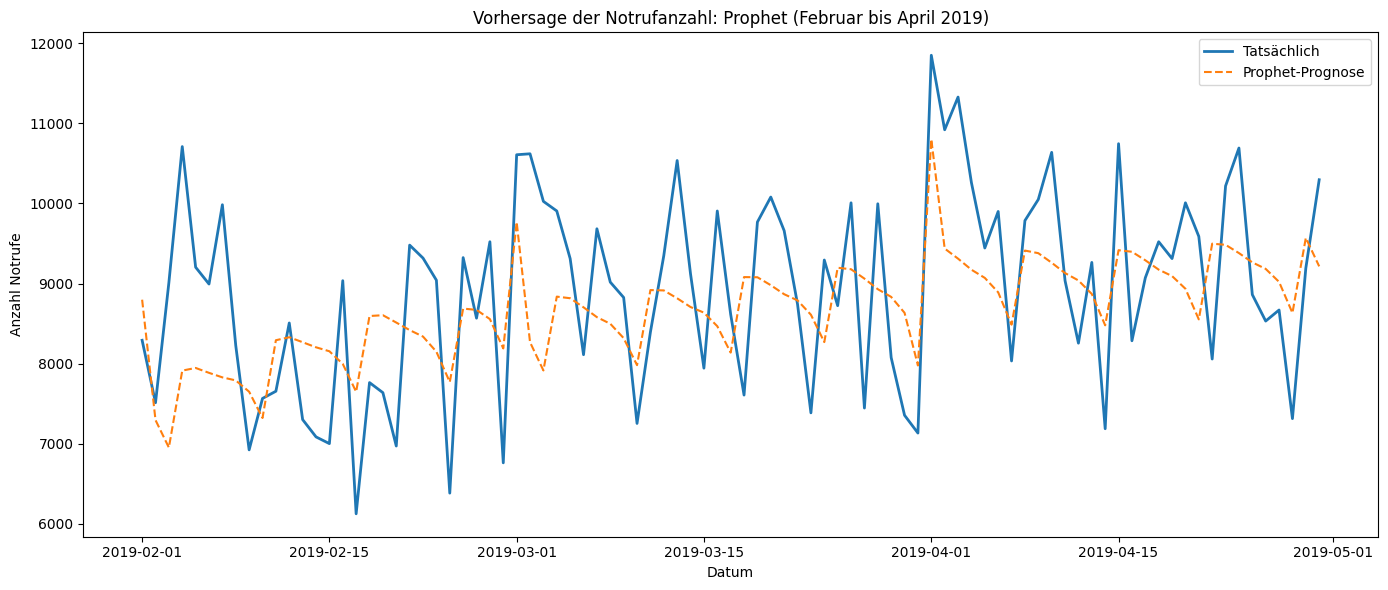

In [3]:
import os
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt
pd.set_option('display.max_colwidth', None)

# --------------------------------------
# 1. Daten & Modelle laden
# --------------------------------------
df_path = os.path.abspath("../data/processed/sickness_table.parquet")
df = pd.read_parquet(df_path)
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')
df = df.rename(columns={"calls": "y"})
df["ds"] = df.index

# Feiertage
holiday_pfad = os.path.abspath("../data/processed/holiday.parquet")
holidays_raw = pd.read_parquet(holiday_pfad)
holiday_df = pd.DataFrame({
    "holiday": holidays_raw["name"],
    "ds": holidays_raw["date"],
    "lower_window": -2,
    "upper_window": 2
})

# Bestes Modell laden
best_path = os.path.abspath("../models/prophet/best_params.parquet")
best_models = pd.read_parquet(best_path)
best_model = best_models.iloc[0]
display(best_model)
features = list(best_model["features"])
params = best_model["params"]
group_name = best_model["groups"]
use_holidays = group_name.endswith("+H")

# --------------------------------------
# 2. Monatsweise Vorhersagefunktion mit Prophet
# --------------------------------------
def predict_calls_for_month(df, vorhersagedatum):
    forecast_start = (vorhersagedatum + pd.offsets.MonthBegin(1)).replace(day=1)
    forecast_end = forecast_start + pd.offsets.MonthEnd(0)
    forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq="D")

    df_train = df.loc[:vorhersagedatum].copy()
    df_model = df_train[["ds", "y"] + features].copy()

    model = Prophet(
        weekly_seasonality=True,
        yearly_seasonality=True,
        holidays=holiday_df if use_holidays else None,
        **params
    )

    for feat in features:
        model.add_regressor(feat)

    model.fit(df_model)

    df_forecast_input = df.loc[forecast_dates][["ds"] + features].copy()
    forecast = model.predict(df_forecast_input)

    df_forecast = df_forecast_input.copy()
    df_forecast["yhat"] = forecast["yhat"].values
    df_eval = df.loc[forecast_start:forecast_end].copy()
    df_forecast["y_true"] = df_eval["y"].values
    df_forecast["abs_error"] = (df_forecast["yhat"] - df_forecast["y_true"]).abs()

    return df_forecast

# --------------------------------------
# 3. Evaluation Februar – April 2019
# --------------------------------------
monate = ["2019-01-15", "2019-02-15", "2019-03-15"]
alle_ergebnisse = []

for vdatum in monate:
    df_monat = predict_calls_for_month(df, pd.Timestamp(vdatum))

    mae = mean_absolute_error(df_monat["y_true"], df_monat["yhat"])
    rmse = sqrt(mean_squared_error(df_monat["y_true"], df_monat["yhat"]))
    under = (df_monat["yhat"] < df_monat["y_true"]).sum() / len(df_monat)
    over = (df_monat["yhat"] > df_monat["y_true"]).sum() / len(df_monat)

    monat = (pd.Timestamp(vdatum) + pd.DateOffset(months=1)).strftime("%B")
    alle_ergebnisse.append({
        "Monat": monat,
        "MAE_Prophet": mae,
        "RMSE_Prophet": rmse,
        "Under_Prophet": under,
        "Over_Prophet": over,
        "df_monat": df_monat
    })

# --------------------------------------
# 4. Ergebnisvergleich als Tabelle
# --------------------------------------
df_metrics = pd.DataFrame(alle_ergebnisse).drop(columns=["df_monat"])
df_avg = df_metrics.drop(columns=["Monat"]).mean().to_frame().T
df_avg["Monat"] = "Durchschnitt"
df_final = pd.concat([df_metrics, df_avg], ignore_index=True)
print("\n📋 Metriken Prophet (Notrufe):")
print(df_final.round(2))

# --------------------------------------
# 5. Visualisierung & Speicherung
# --------------------------------------
alle_monate = pd.concat([eintrag["df_monat"] for eintrag in alle_ergebnisse])

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(alle_monate.index, alle_monate["y_true"], label="Tatsächlich", linewidth=2)
ax.plot(alle_monate.index, alle_monate["yhat"], label="Prophet-Prognose", linestyle='--')
ax.set_title("Vorhersage der Notrufanzahl: Prophet (Februar bis April 2019)")
ax.set_ylabel("Anzahl Notrufe")
ax.set_xlabel("Datum")
ax.legend()
fig.tight_layout()

# Grafik speichern
fig_dir = os.path.abspath("../reports/figures/prophet")
os.makedirs(fig_dir, exist_ok=True)
fig_path = os.path.join(fig_dir, "prophet_forecast_calls_feb_apr_2019.png")
fig.savefig(fig_path, dpi=300)

plt.show()

# Prognosedaten speichern
forecast_path = os.path.abspath("../data/predictions/prophet_calls.parquet")
os.makedirs(os.path.dirname(forecast_path), exist_ok=True)
alle_monate.to_parquet(forecast_path, index=True)
